# Exploring categorical encodings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from plotnine import *

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

## Data from Kaggle

Kaggle dataset for categorical encodings: https://www.kaggle.com/c/cat-in-the-dat/data

In [3]:
def read_csv_from_drive(url: str) -> pd.DataFrame:
  url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
  return pd.read_csv(url)

# Read data from csv file and drop the 'id' column as it won't be needed.
data = read_csv_from_drive(
  'https://drive.google.com/file/d/1Q8Q62LS3XY3yjJOIWTM-cAN-9FlOHMOU/view?usp=drive_link'
).drop(columns = ['id'])

In [4]:
data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


"The data contains binary features (bin_*), nominal features (nom_*), ordinal features (ord_*) as well as (potentially cyclical) day (of the week) and month features. The string ordinal features ord_{3-5} are lexically ordered according to string.ascii_letters."

In [5]:
data.shape

(300000, 24)

## Data Split

In [6]:
def split_sets(data: pd.DataFrame,
               target_column_name: str = 'target',
               test_size: float = 0.15,
               validation_size: float = 0.20,
               seed: int = 8675309) -> tuple:
  """Split a data frame into train/validation/test sets.

  Args:
    data (pd.DataFrame): The data we'd like to split.
    target_column_name (str): The column name in the data containing the target.
    test_size (float): The proportion of the data to use for test.
    validation_size (float): The proportion of training data to use for
      validation.
    seed (int): A seed to supply to train_test_split.

  Returns:
    A tuple containing the train/validation/test sets for both the targets (Y)
    and features (X).
  """

  # Extract the Y and X values from the data.
  Y = data[target_column_name].values
  X = data.drop(columns=[target_column_name])

  # Split data into (validation + train) and test.
  x_train_val, x_test, y_train_val, y_test = train_test_split(
      X, Y, test_size = test_size, random_state = seed)
  x_train_val = x_train_val.reset_index(drop = True)
  x_test = x_test.reset_index(drop = True)

  # Split again into validation and train.
  x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size = validation_size, random_state = seed)

  return (
    x_train, y_train, x_val, y_val, x_test, y_test, x_train_val, y_train_val
  )

In [7]:
x_train, y_train, x_val, y_val, x_test, y_test, x_train_val, y_train_val = (
  split_sets(data)
)

In [8]:
x_train.shape, x_val.shape, x_test.shape, x_train_val.shape

((204000, 23), (51000, 23), (45000, 23), (255000, 23))

### EDA

In [9]:
x_train.describe()

,bin_0,bin_1,bin_2,ord_0,day,month
count,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000
mean,0.127941,0.256912,0.383020,1.480147,3.005500,5.774328
std,0.334025,0.436931,0.486124,0.712597,1.814126,3.845858
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000
50%,0.000000,0.000000,0.000000,1.000000,3.000000,4.000000
75%,0.000000,1.000000,1.000000,2.000000,4.000000,9.000000
max,1.000000,1.000000,1.000000,3.000000,7.000000,12.000000


`bin_0` has 75% quantile 0. Let's look more closely

In [10]:
np.quantile(x_train.bin_0.values, [0.75, 0.8, 0.85, 0.88, 0.90, 0.99], axis=0)

array([0., 0., 0., 1., 1., 1.])

In [11]:
x_train.bin_0.value_counts() / x_train.shape[0]

bin_0
0    0.872059
1    0.127941
Name: count, dtype: float64

Approx 87% of the data are 0s. I will keep this col for now but it may not be that useful. Now let's take a look at the target.

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
unique, counts

(array([0, 1]), array([141501,  62499]))

In [ ]:
counts / counts.sum()

array([0.69363235, 0.30636765])

30% of the target data are 1s. A little imbalanced but not a big deal, since we will be using AUC as a metric instead of accuracy.

Now let's look at how many unique values each feature has.

In [ ]:
{col: len(x_train[col].unique()) for col in x_train.columns}

{'bin_0': 2,
 'bin_1': 2,
 'bin_2': 2,
 'bin_3': 2,
 'bin_4': 2,
 'nom_0': 3,
 'nom_1': 6,
 'nom_2': 6,
 'nom_3': 6,
 'nom_4': 4,
 'nom_5': 222,
 'nom_6': 522,
 'nom_7': 1220,
 'nom_8': 2212,
 'nom_9': 11860,
 'ord_0': 3,
 'ord_1': 5,
 'ord_2': 6,
 'ord_3': 15,
 'ord_4': 26,
 'ord_5': 192,
 'day': 7,
 'month': 12}

Some of these values are large. A large # of categories is  not a big deal for label encoding but it could be for one-hot encoding!

Let's visualize the fraction of 1s in the target as broken down by each class of predictors.

In [ ]:
def summarize_data(x: np.array, y: np.array) -> pd.DataFrame:
  """Summarize data into a pandas data frame for easier plotting.

  Args:
    x (np.array): An np.array of size (n, p) with columns containing the
      features.
    y (np.array): An np.array of size (n, ) containing the targets.

  Returns:
    A data frame with columns:
      'feature': The feature name
      'value': The value of the feature
      'counts': The unique count of feature value
      'mean_target': The mean target of a feature value
      'p_counts': The proportion of rows of a feature value
  """

  x_counts = (
      pd.DataFrame(x)
        .assign(target = y)
        # Melt the wide matrix into a long data frame.
        .melt(id_vars = 'target',
              value_vars = x.columns,
              var_name = 'feature')
        # Add a counter to each row that we'll sum.
        .assign(counts = 1)
        # Aggregate by 'feature' and 'value'.
        .groupby(['feature', 'value'])
        .agg(counts = ('counts', 'sum'),
            mean_target = ('target', 'mean'))
        .reset_index()
  )

  # Add the proporition of counts by 'feature'.
  x_counts['p_counts'] = (
      x_counts['counts'] /
        x_counts.groupby(['feature'])['counts'].transform('sum')
  )

  return x_counts

In [ ]:
def my_theme(figure_size: list = (10, 6), font_size: int = 16) -> theme:
  """Create a plotnine theme with larger fonts.

  Args:
    figure_size (list): The size of the figure in inches.
    font_size (int): The size of the font to use in the plot.

  Returns: A plotnine theme
  """

  th = (
      theme_bw() +
      theme(
        figure_size=figure_size,
        legend_position='top',
        legend_box='horizontal',
        legend_direction='horizontal',
        legend_key=element_blank(),
        legend_title=element_blank(),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        axis_line=element_line(size=0.5),
        axis_text=element_text(size=font_size),
        axis_title=element_text(size=font_size),
        strip_text=element_text(size=font_size),
        legend_text=element_text(size=font_size),
        strip_background=element_rect(fill='white'),
      )
  )
  return th

def percent(x: np.array, digits: int = 0) -> np.array:
  """Convert an array of numbers to percentages.

  Args:
    x (np.array): A numeric array.
    digits (int): The number of digits to include after the decimal point.

  Returns:
    A string array with the percentages.
  """

  return [('%0.' + str(digits) + 'f%%') % (v * 100) for v in x]

def max_label_print(x: np.array, max_print: int = 30) -> np.array:
  """Return labels only if there are fewer than `max_print`.

  Args:
    x (np.array): An array containing the labels.
    max_print (int): The maximum number of labels to print.

  Returns:
    An array the same length as the input array. If the input array is longer
    `max_print` then return an array of empty strings. Otherwise return the
    original array.
  """

  if len(x) <= max_print:
    return x
  return np.repeat('', len(x))

In [ ]:
from pandas.core.indexes import category
def plot_feature(data: pd.DataFrame,
                 features: np.array,
                 y_ref: float = None,
                 y_ref_color: str = 'firebrick',
                 fix_y_scale: bool = False,
                 yval: str = 'mean_target',
                 fill: str = 'steelblue',
                 font_size: int = 16,
                 figure_size: list = (10, 6)) -> ggplot:
  """Plot a metric vs. the levels of a feature.

  Args:
    data (pd.DataFrame): The output from `summarize_data`.
    features (np.array): An array of features to plot.
    y_ref (float): The value of a reference line.
    y_ref_color (str): The color of the reference line.
    fix_y_scale (bool): If True, the fix the y-limits to (0, 1).
    yval (str): The column in `data` to plot on the y-axis.
    fill (str): The fill color of the bar plot.
    font_size (int): Variable to pass to `my_theme`.
    figure_size (list): Variable to pass to `figure_size`.

  Returns: A `ggplot` object.
  """

  # Select only the features that we want to plot.
  data = data[data['feature'].isin(features)]
  # Order the features in based on the input argument.
  data['feature'] = pd.Categorical(data['feature'], categories = features)

  # Force the x-axis to be categorical.
  data['values'] = data['value'].astype('category')

  # Determine the y-limits
  ylim = [0, 1] if fix_y_scale else [0, np.max(data[yval])]

  # Create the bar plot.
  gg = ggplot(data, aes(x = 'value', y = yval))
  gg += geom_bar(stat = 'identity', fill = fill, color = 'white')
  if y_ref is not None:
    gg += geom_hline(yintercept = y_ref, color = y_ref_color, size = 2)
  gg += my_theme(figure_size, font_size)
  gg += facet_wrap('~feature', scales = 'free_x')
  gg += scale_x_discrete(name = '', labels = lambda l: max_label_print(l))
  gg += scale_y_continuous(labels = lambda l: percent(l), limits = ylim)

  return gg

### Plot a single feature at a time.

In [ ]:
x_train_counts = summarize_data(x_train, y_train)

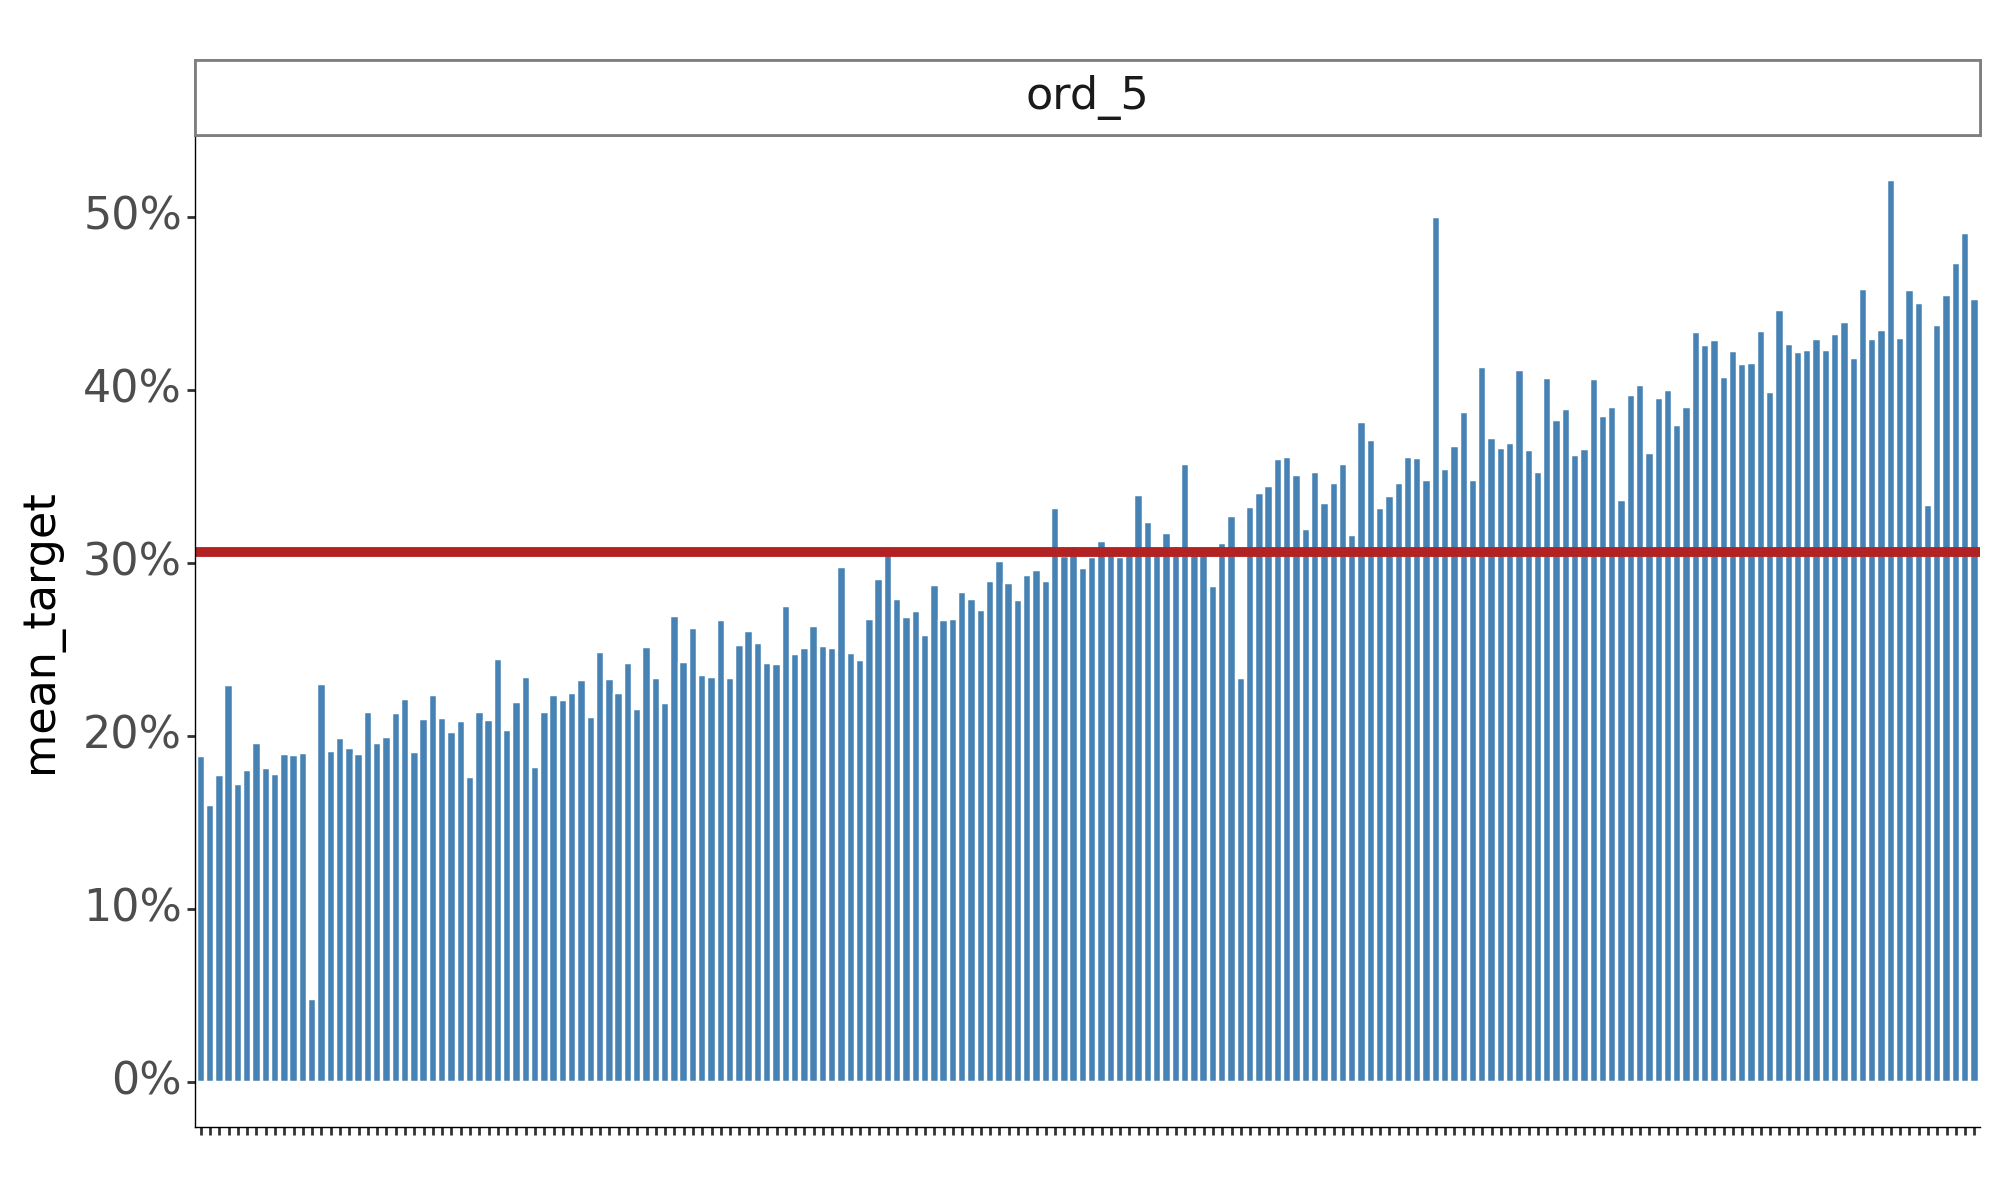

<Figure Size: (1000 x 600)>

In [ ]:
feature = 'ord_0' # @param ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month']
yval = 'mean_target'# @param ['mean_target', 'count', 'p_count']
fix_y_scale = True # @param ['True', 'False']
show_y_ref = True # @param ['True', 'False']

y_ref = None
if show_y_ref & (yval == 'mean_target'):
  y_ref = y_train.mean()

plot_feature(x_train_counts, [feature], y_ref = y_ref)

### Plot multiple features at a time.

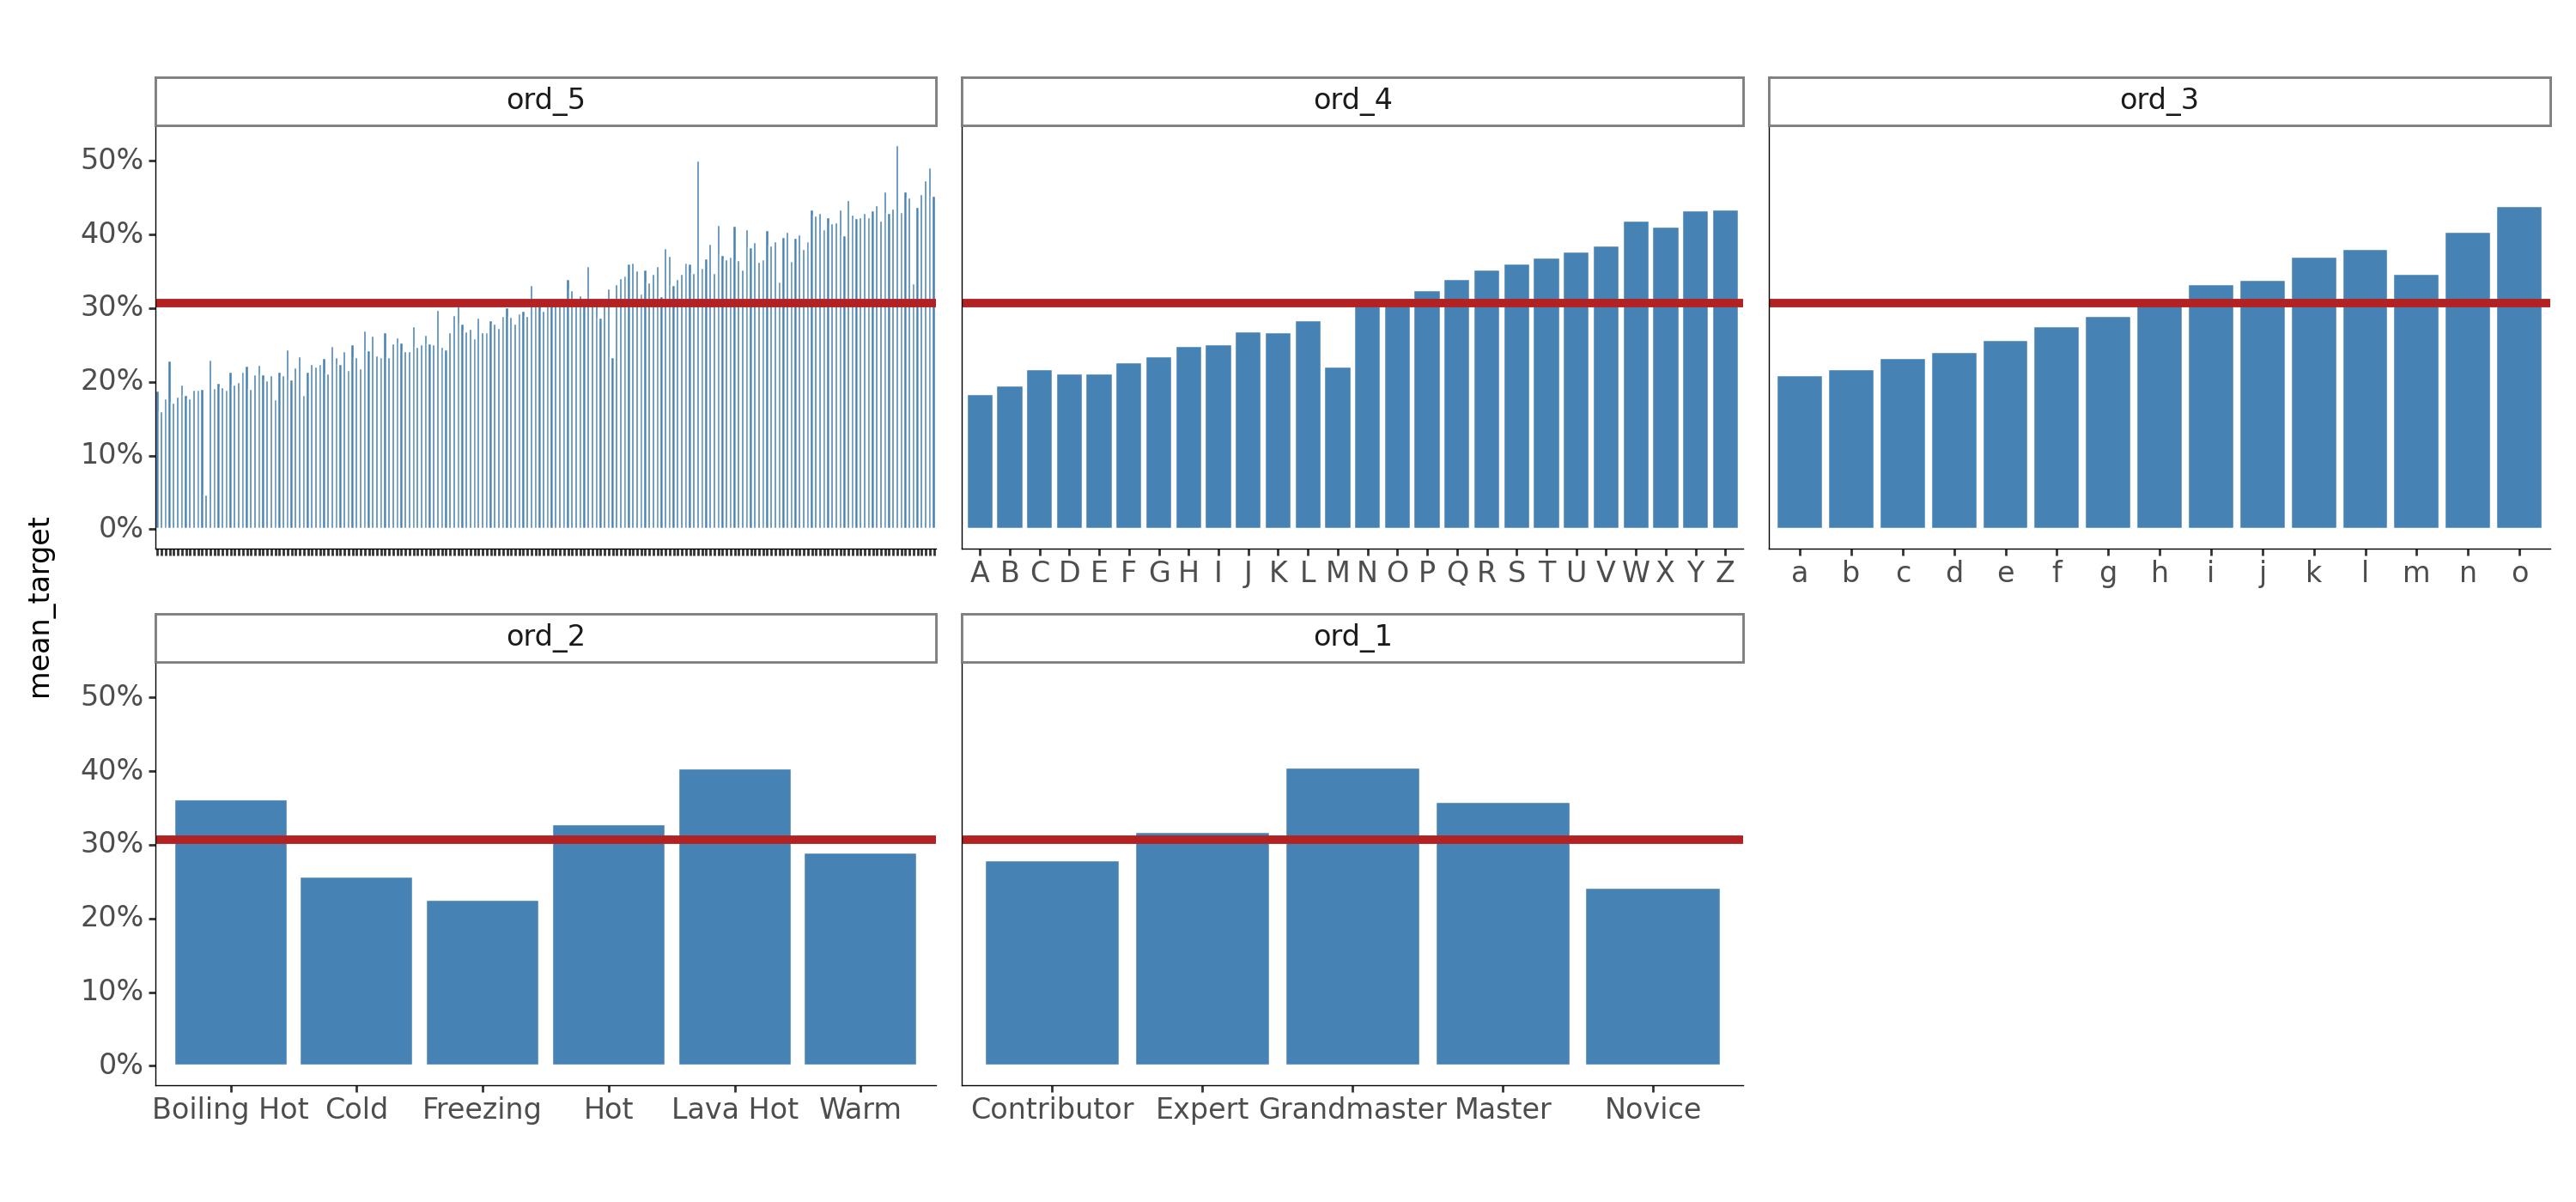

<Figure Size: (1500 x 700)>

In [ ]:
bin = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']
# This one (`nom`) takes a while because of how many levels there are.
# Plot is unreadable too. Optional: Create a better visualization.
nom = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7',
       'nom_8', 'nom_9']
ord = ['ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5']
dm = ['day', 'month']
plot_feature(
    x_train_counts,
    features = ord[::-1],
    y_ref = np.mean(y_train),
    font_size = 12,
    figure_size = (15, 7)
)

### Approach #1:
Encode categorical features with label encoding and use a tree based model

In [ ]:
from sklearn.preprocessing import LabelEncoder

def label_encoding(x: np.array,
                   add_unknown: bool = True,
                   unknown_value: str = 'Unknown'):
  """Encode a categorical column.

  Args:
    x (np.array): An array to encode.
    add_unknown (bool): If True, add an 'unknown' label.
    unknown_value (str): The value to use in the 'unknown' label.

  Returns:
    A LabelEncoder.
  """

  le = LabelEncoder()
  uniq = np.unique(x)
  if add_unknown:
    uniq = np.concatenate((np.array([unknown_value]), uniq))
  le.fit(uniq)
  return le

In [ ]:
def transform_column(le: LabelEncoder,
                     index: int,
                     x_train: np.array,
                     x_val: np.array,
                     x_test: np.array,
                     x_train_val: np.array,
                     unknown_value: str = 'Unknown') -> None:
  classes = le.classes_

  x_train[index] = le.transform(x_train[index])

  val = [x if x in classes else unknown_value for x in x_val[index]]
  x_val[index] = le.transform(val)

  test = [x if x in classes else unknown_value for x in x_test[index]]
  x_test[index] = le.transform(test)

  train_val = [x if x in classes else unknown_value for x in x_train_val[index]]
  x_train_val[index] = le.transform(train_val)

In [ ]:
x_train.nom_0.values

array(['Green', 'Green', 'Red', ..., 'Red', 'Green', 'Green'],
      dtype=object)

In [ ]:
le = label_encoding(x_train.nom_0.values)

In [ ]:
le.classes_

array(['Blue', 'Green', 'Red', 'Unknown'], dtype=object)

In [ ]:
le.transform(le.classes_)

array([0, 1, 2, 3])

In [ ]:
le.transform(["Unknown", "Red"])

array([3, 2])

In [ ]:
fake_nom_0 = np.array(['Blue', 'Green', 'Red', 'W'])

# notice a new value 'W' le.transform would break (try it)
# le.transform(fake_nom_0)

In [ ]:
# change "W" for 'Unknown' and then transform
[x if x in le.classes_ else 'Unknown' for x in fake_nom_0]

['Blue', 'Green', 'Red', 'Unknown']

In [ ]:
def transform_data(x_train: pd.DataFrame,
                   x_val: pd.DataFrame,
                   x_test: pd.DataFrame,
                   x_train_val: pd.DataFrame) -> tuple:
  """Encode all the columns in train, validation and test data.

  Args:
    x_train (pd.DataFrame): Training data.
    x_val (pd.DataFrame): Validation data.
    x_test (pd.DataFrame): Test data.
    x_train_val (pd.DataFrame): Training and validation together.

  Returns:
    Copies of the inputs with the transformed categorical data.
  """

  # Copy the data frames so we don't overwrite the originals.
  x_train_e = x_train.copy()
  x_val_e = x_val.copy()
  x_test_e = x_test.copy()
  x_train_val_e = x_train_val.copy()

  # Determine which columns are numeric.
  ncol = x_train_e.shape[1]
  num_cols = x_train_e.iloc[:ncol, ].applymap(np.isreal).all(0)

  for index, value in num_cols.items():
    if not value:
      # If a binary column (determined by the name), don't add an 'unknown'
      # label. Can you think of a better way to do this, rather than rely on
      # string matching?
      is_binary = index.startswith('bin')
      add_unknown = False if is_binary else True
      # Create the encoder based on the training data.
      le = label_encoding(x_train_e[index].values, add_unknown = add_unknown)
      # Transform all the data.
      transform_column(le, index, x_train_e, x_val_e, x_test_e, x_train_val_e)

  # Return the encoded data.
  return x_train_e, x_val_e, x_test_e, x_train_val_e

In [ ]:
x_train_e, x_val_e, x_test_e, x_train_val_e = transform_data(
    x_train, x_val, x_test, x_train_val)

In [ ]:
x_train_e.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
229702,0,0,0,0,1,1,2,2,0,1,...,441,6475,2,1,2,2,0,162,5,1
26162,0,0,0,0,0,1,1,5,1,0,...,1530,10879,1,4,2,11,15,58,1,10
187615,0,0,0,0,1,2,1,5,1,0,...,1999,6347,1,4,2,12,3,67,2,4
248270,0,0,0,1,1,2,4,0,5,3,...,537,6316,2,1,6,5,9,160,5,9
245966,0,0,1,1,1,0,3,1,3,0,...,1447,1287,1,0,4,9,14,171,2,4


In [ ]:
x_test_e.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0,0,0,1,0,2,3,1,3,2,...,1993,6215,2,2,6,11,9,6,1,1
1,0,0,1,1,0,1,1,5,5,1,...,1957,402,3,1,2,6,20,37,3,11
2,0,0,1,1,1,1,5,5,1,0,...,97,855,3,2,2,6,15,6,7,10
3,1,0,1,0,1,1,3,3,3,0,...,266,355,3,4,0,8,26,165,4,12
4,0,0,1,0,0,1,2,0,0,2,...,696,10395,1,2,1,1,11,168,5,5


### Doing Randomized Search with validation set

In [ ]:
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import roc_auc_score

In [ ]:
split_index = [-1 if i in x_train_e.index else 0 for i in x_train_val_e.index]
pds = PredefinedSplit(test_fold = split_index)

In [ ]:
max_depth = [int(x) for x in np.linspace(6, 20, num = 5)]
max_features = [x for x in np.linspace(0.1, 1, num = 5)]
min_samples_leaf = [int(x) for x in np.linspace(6, 20, num = 5)]

In [ ]:
random_grid = {
  'max_features': max_features,
  'max_depth': max_depth,
  'min_samples_leaf': min_samples_leaf
}

In [ ]:
rf = RandomForestClassifier()

In [ ]:
rf_random = RandomizedSearchCV(
  estimator = rf,
  param_distributions = random_grid,
  scoring = 'roc_auc',
  n_iter = 30,
  cv = pds,
  random_state = 8675309,
  verbose = 2,
  n_jobs = -1
)

In [ ]:
# Grab some coffee. This will take a while.
rf_random.fit(x_train_val_e, y_train_val)

Fitting 1 folds for each of 30 candidates, totalling 30 fits


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
                   estimator=RandomForestClassifier(), n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [6, 9, 13, 16, 20],
                                        'max_features': [0.1, 0.325, 0.55,
                                                         0.775, 1.0],
                                        'min_samples_leaf': [6, 9, 13, 16, 20]},
                   random_state=8675309, scoring='roc_auc', verbose=2)

In [ ]:
roc_auc_score(y_test, rf_random.predict_proba(x_test_e)[:,1])

0.7495552859680029

In [ ]:
importances = rf_random.best_estimator_.feature_importances_

In [ ]:
importances

array([0.00318327, 0.02715573, 0.00753691, 0.00815708, 0.01106011,
       0.03793766, 0.02568244, 0.02118154, 0.02284119, 0.03215678,
       0.04264346, 0.04425522, 0.04453689, 0.04395719, 0.04413137,
       0.03088228, 0.07051867, 0.06581975, 0.07889281, 0.11374859,
       0.14629147, 0.02626893, 0.05116066])

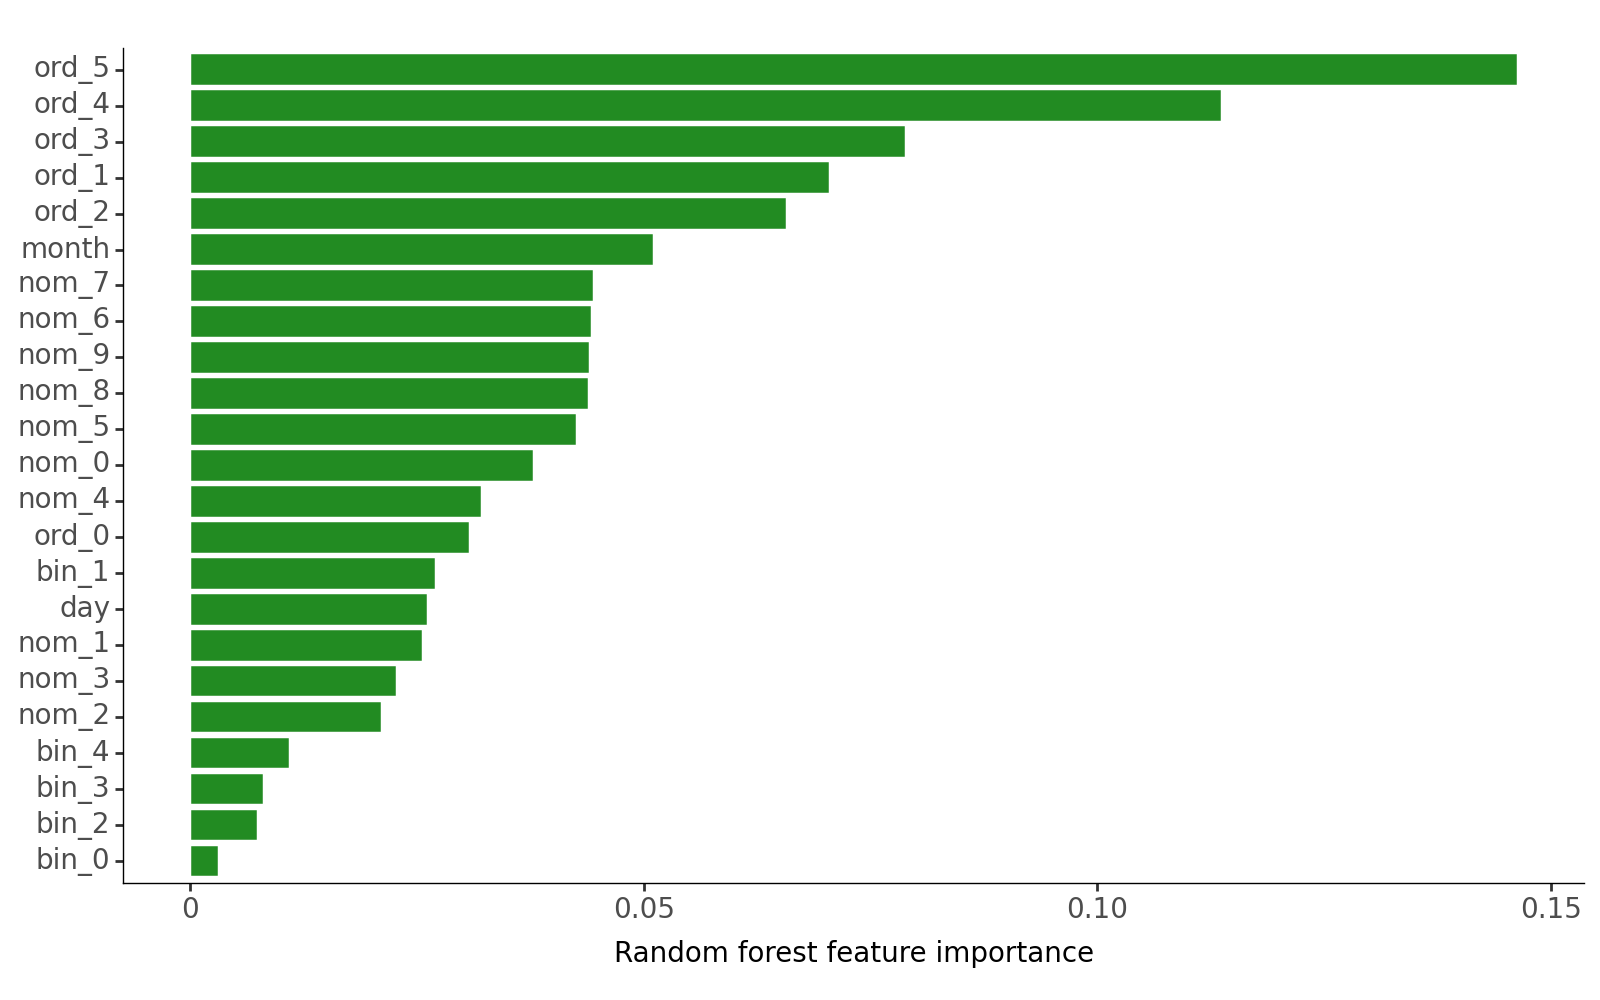

<Figure Size: (800 x 500)>

In [ ]:
forest_importances = (
  pd.DataFrame({'feature': x_train.columns, 'value': importances})
  # Sort by importance.
  .sort_values('value', ascending = False)
  # Makes sure order of feature is is ascending order of value.
  .pipe(lambda p: p.assign(
    # Set the categories to be in reverse order so the horizontal barchart has
    # the biggest on top.
    feature = pd.Categorical(p.feature, categories = p.feature[::-1])
  ))
)

# Plot the feature importance on a barchart.
(
    ggplot(forest_importances, aes(x = 'feature', y = 'value')) +
      geom_bar(stat = 'identity', fill = 'forestgreen', color = 'white') +
      ylab('Random forest feature importance') +
      # Create a horiztonal barchart so the feature labels are more redable.
      coord_flip() +
      my_theme(font_size = 10, figure_size = (8, 5)) +
      theme(axis_title_y = element_blank())
)

### Approach 2:
Encoding for logistic regression

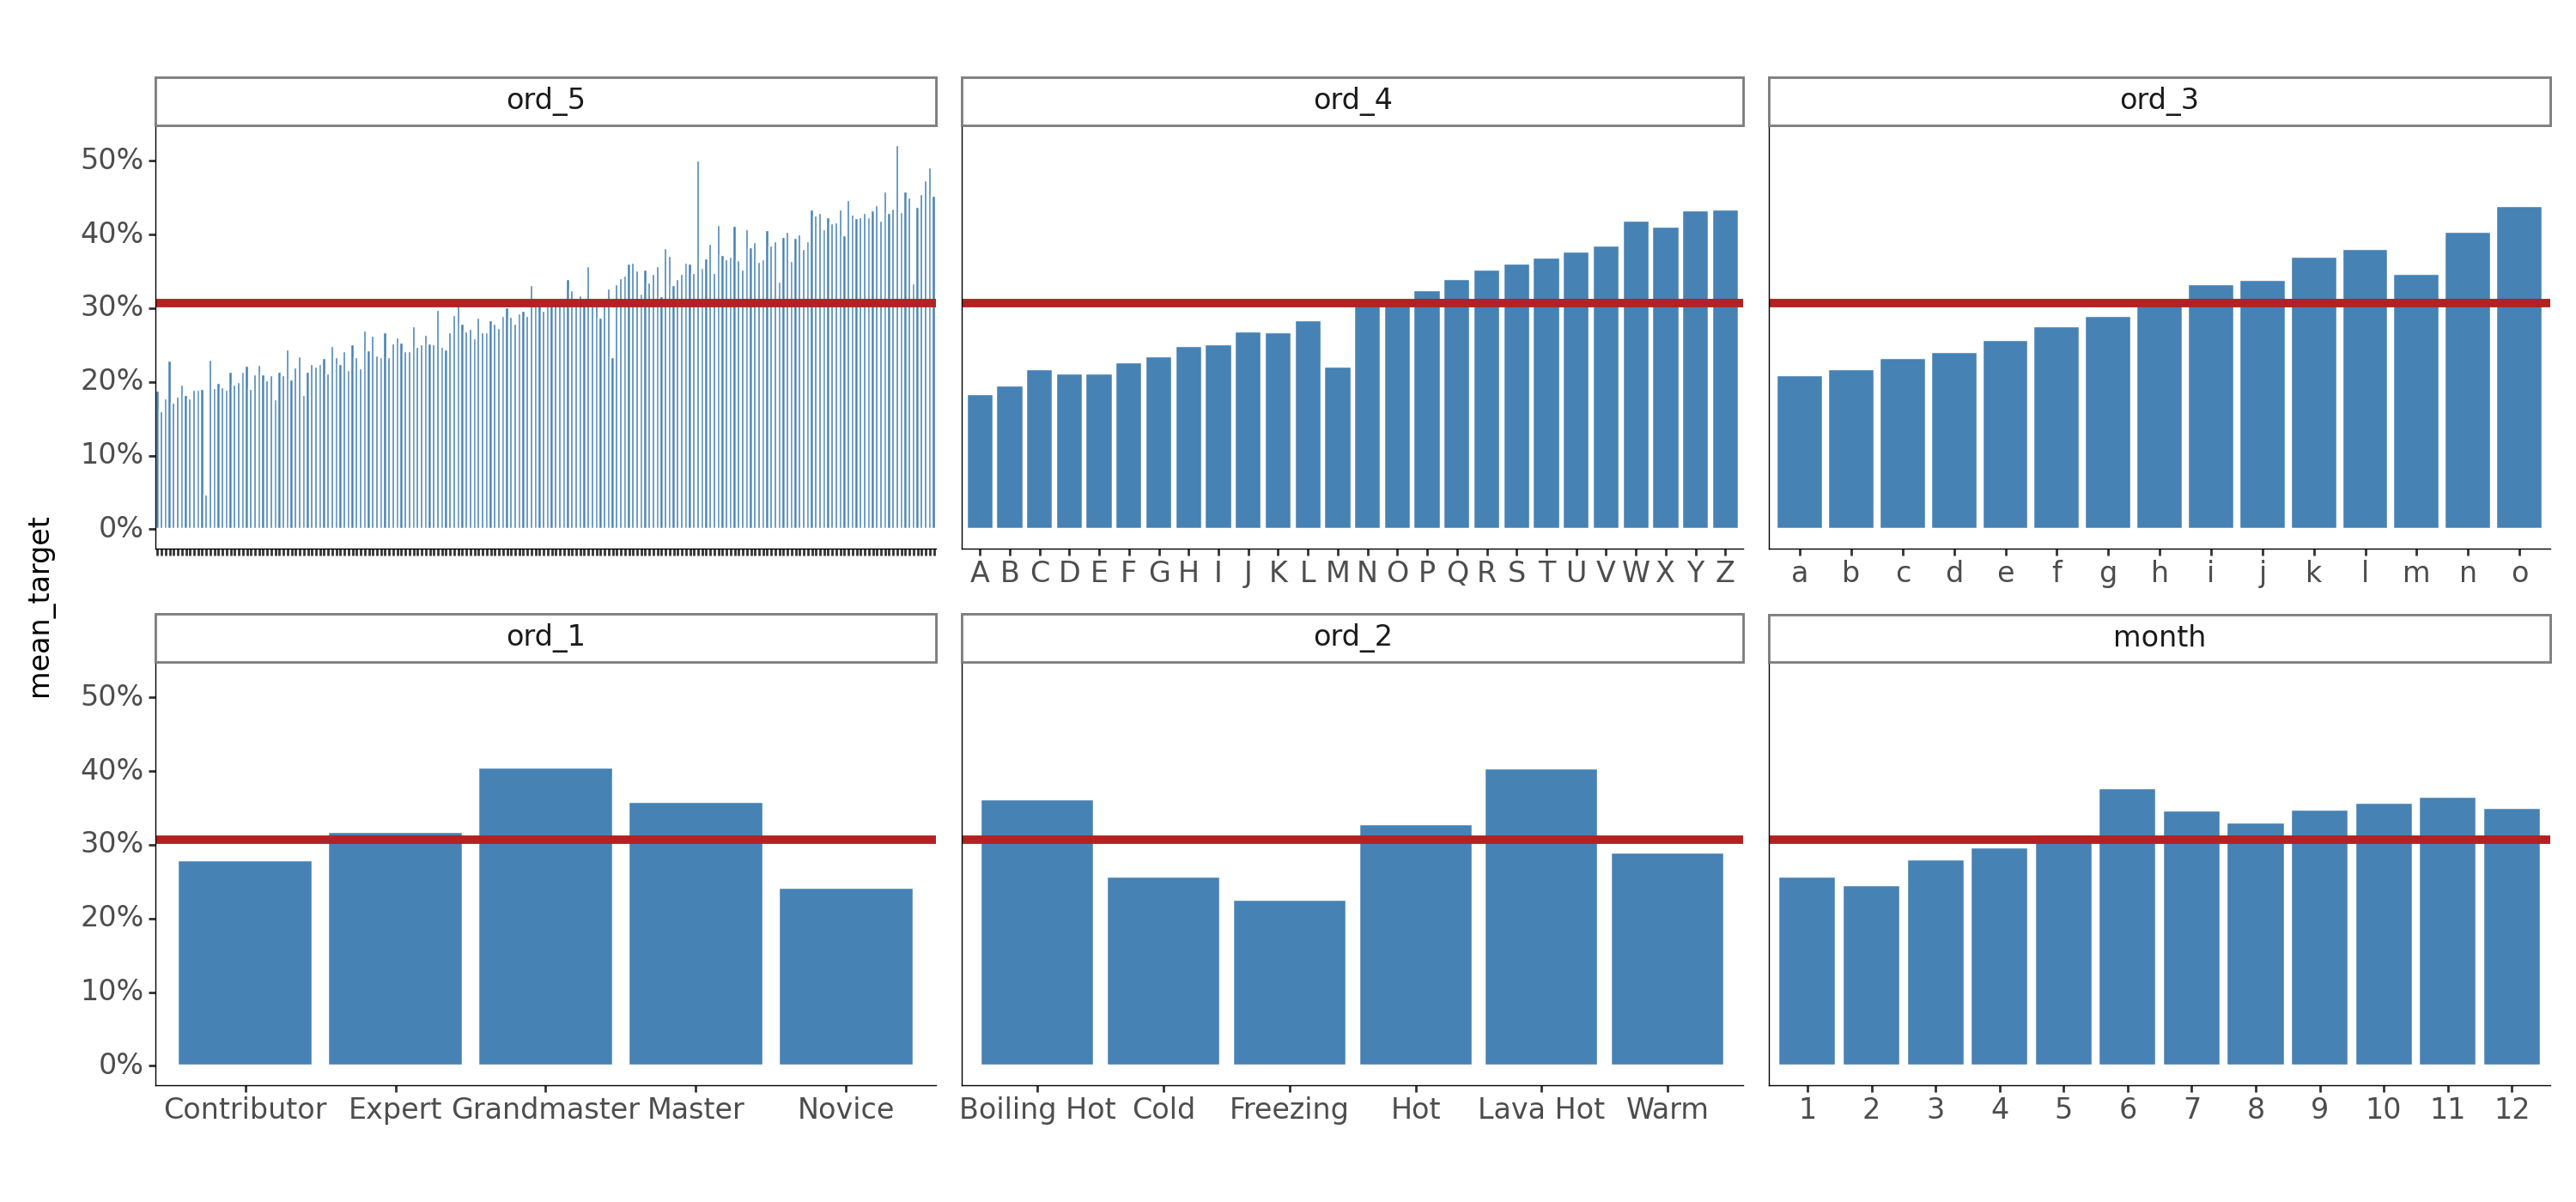

<Figure Size: (1500 x 700)>

In [ ]:
# Plot the columns with the highest importance. These ordinal variables seem to
# have a quasilinear relationship with the target
plot_feature(
    x_train_counts,
    features = forest_importances['feature'][:6].values.astype('str'),
    y_ref = np.mean(y_train),
    font_size = 12,
    figure_size = (15, 7)
)

#### Feature hashing for high cardinality nominal features

In [ ]:
from sklearn.feature_extraction import FeatureHasher

In [ ]:
def hashing_trick(x: pd.DataFrame, n_features: int = 3) -> pd.DataFrame:
  """Create a hash from a column of strings.

  Args:
    x (pd.DataFrame): A single column as a pandas data frame.
    n_features (int): The number of features (columns) in the output matrices.

  Returns:
    A pandas data frame with 1 row and `n_features` columns containing the
    hashed values.
  """

  # Create new columns for output data frame.
  names = [x.name + "_" + str(i + 1) for i in range(n_features)]

  # Build hasher function.
  h = FeatureHasher(input_type = 'string', n_features = n_features)

  # Transform the column and convert to an array.
  hashed = h.transform(x.to_numpy().reshape(-1, 1)).toarray()

  # Add `names` and return hashed field.
  return pd.DataFrame(hashed, columns = names)

In [ ]:
f = 'nom_1'
x_train[f][:5]

229702       Square
26162       Polygon
187615      Polygon
248270    Trapezoid
245966         Star
Name: nom_1, dtype: object

In [ ]:
hashing_trick(x_train[f][:5])

,nom_1_1,nom_1_2,nom_1_3
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,-1.0,0.0,0.0
4,1.0,0.0,0.0


In [ ]:
# All column names.
x_train.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month'],
      dtype='object')

Thes columns we keep the same
['ord_0', 'ord_3', 'ord_4', 'ord_5', 'month']

In [ ]:
# Columns we won't need to change.
['ord_0', 'ord_3', 'ord_4', 'ord_5', 'month']

['ord_0', 'ord_3', 'ord_4', 'ord_5', 'month']

In [ ]:
# Columns that need encoding.
num_cols = x_train.iloc[:20,].applymap(np.isreal).all(0)
cols_label_encoding = []
cols_numerical = []
for index, value in num_cols.items():
    if value: cols_numerical.append(index)
    if not value:
        binary = index.startswith('bin')
        if binary or index in ['ord_0', 'ord_3', 'ord_4', 'ord_5', 'month']:
            cols_label_encoding.append(index)

In [ ]:
cols_label_encoding

['bin_3', 'bin_4', 'ord_3', 'ord_4', 'ord_5']

In [ ]:
cols_numerical

['bin_0', 'bin_1', 'bin_2', 'ord_0', 'day', 'month']

In [ ]:
# rest of the columns for feature hashing
cols_feat_hashing = [
    x for x in x_train.columns
    if x not in (cols_numerical + cols_label_encoding)
]

cols_feat_hashing

['nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'nom_5',
 'nom_6',
 'nom_7',
 'nom_8',
 'nom_9',
 'ord_1',
 'ord_2']

#### Split columns for feature hashing

In [ ]:
x_train_hash = x_train[cols_feat_hashing].copy()
x_val_hash = x_val[cols_feat_hashing].copy()
x_test_hash = x_test[cols_feat_hashing].copy()
x_train_hash.head()

,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_1,ord_2
229702,Green,Square,Dog,Canada,Oboe,1f1702d2f,5fa8beadb,6f3940b72,3320ed3a6,8ca261e9d,Expert,Freezing
26162,Green,Polygon,Snake,China,Bassoon,534be2753,113deddc9,b23e16a87,b1ebfd817,eabcb6e2a,Novice,Freezing
187615,Red,Polygon,Snake,China,Bassoon,60a44c8f4,bb219c9ac,8783b512a,e7ed9ec87,89ee8dd54,Novice,Freezing
248270,Red,Trapezoid,Axolotl,Russia,Theremin,b0faff28f,e7073f6a2,23b77929a,406459a0b,8923a846a,Expert,Warm
245966,Blue,Star,Cat,Finland,Bassoon,472efea17,c0f1061ee,8cae1caeb,a619cc437,1b6f1333e,Contributor,Lava Hot


In [ ]:
# delete feature hashing columns from the main dataframes
x_train_2 = x_train.drop(columns=cols_feat_hashing).copy()
x_val_2 = x_val.drop(columns=cols_feat_hashing).copy()
x_test_2 = x_test.drop(columns=cols_feat_hashing).copy()
x_train_val_2 = x_train_val.drop(columns=cols_feat_hashing).copy()

In [ ]:
x_train_2.reset_index(drop=True, inplace=True)
x_val_2.reset_index(drop=True, inplace=True)
x_test_2.reset_index(drop=True, inplace=True)
x_train_val_2.reset_index(drop=True, inplace=True)

In [ ]:
for f in cols_label_encoding:
  is_binary = f.startswith('bin')
  le = label_encoding(x_train[f].values, add_unknown = not is_binary)
  transform_column(le, f, x_train_2, x_val_2, x_test_2, x_train_val_2)

In [ ]:
x_train_2.tail()

,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_3,ord_4,ord_5,day,month
203995,0,0,1,1,1,1,5,18,80,3,3
203996,0,1,1,0,1,1,12,0,83,4,5
203997,0,0,1,1,1,1,1,0,167,2,12
203998,0,0,0,1,1,1,6,0,24,1,2
203999,0,1,1,1,1,1,12,24,165,2,12


In [ ]:
cols_feat_hashing

['nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'nom_5',
 'nom_6',
 'nom_7',
 'nom_8',
 'nom_9',
 'ord_1',
 'ord_2']

In [ ]:
x_train_hashed = pd.concat([hashing_trick(x_train_hash[f])
                            for f in cols_feat_hashing], axis=1)
x_val_hashed = pd.concat([hashing_trick(x_val_hash[f])
                            for f in cols_feat_hashing], axis=1)
x_test_hashed = pd.concat([hashing_trick(x_test_hash[f])
                            for f in cols_feat_hashing], axis=1)

In [ ]:
x_test_hashed.shape, x_val_hashed.shape

((45000, 36), (51000, 36))

In [ ]:
x_train_hashed.tail()

,nom_0_1,nom_0_2,nom_0_3,nom_1_1,nom_1_2,nom_1_3,nom_2_1,nom_2_2,nom_2_3,nom_3_1,...,nom_8_3,nom_9_1,nom_9_2,nom_9_3,ord_1_1,ord_1_2,ord_1_3,ord_2_1,ord_2_2,ord_2_3
203995,-1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
203996,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0
203997,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0
203998,0.0,1.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
203999,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0


In [ ]:
x_test_2.shape, x_test_hashed.shape

((45000, 11), (45000, 36))

In [ ]:
x_train_3 = pd.concat([x_train_2, x_train_hashed], axis=1)
x_val_3 = pd.concat([x_val_2, x_val_hashed], axis=1)
x_test_3 = pd.concat([x_test_2, x_test_hashed], axis=1)

In [ ]:
x_train_3.tail()

,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_3,ord_4,ord_5,day,...,nom_8_3,nom_9_1,nom_9_2,nom_9_3,ord_1_1,ord_1_2,ord_1_3,ord_2_1,ord_2_2,ord_2_3
203995,0,0,1,1,1,1,5,18,80,3,...,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
203996,0,1,1,0,1,1,12,0,83,4,...,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0
203997,0,0,1,1,1,1,1,0,167,2,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0
203998,0,0,0,1,1,1,6,0,24,1,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
203999,0,1,1,1,1,1,12,24,165,2,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train_3)
X_val = scaler.fit_transform(x_val_3)
X_test = scaler.fit_transform(x_test_3)

In [ ]:
# Determine C value using validation data set.
scores = np.array([])
Cval = np.array([0.001, 0.01, 0.1, 1, 10, 100])
for C in Cval:
    # Train for a given value of C.
    clf = LogisticRegression(C = C).fit(X_train, y_train)
    # Determine AUC based on validation (X_val).
    y_hat = clf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_hat)
    # Append scores.
    scores = np.append(scores, auc)

In [ ]:
auc_data = pd.DataFrame({'Cval': Cval, 'scores': scores})

auc_data

,Cval,scores
0,0.001,0.745932
1,0.010,0.745937
2,0.100,0.745936
3,1.000,0.745936
4,10.000,0.745936
5,100.000,0.745936


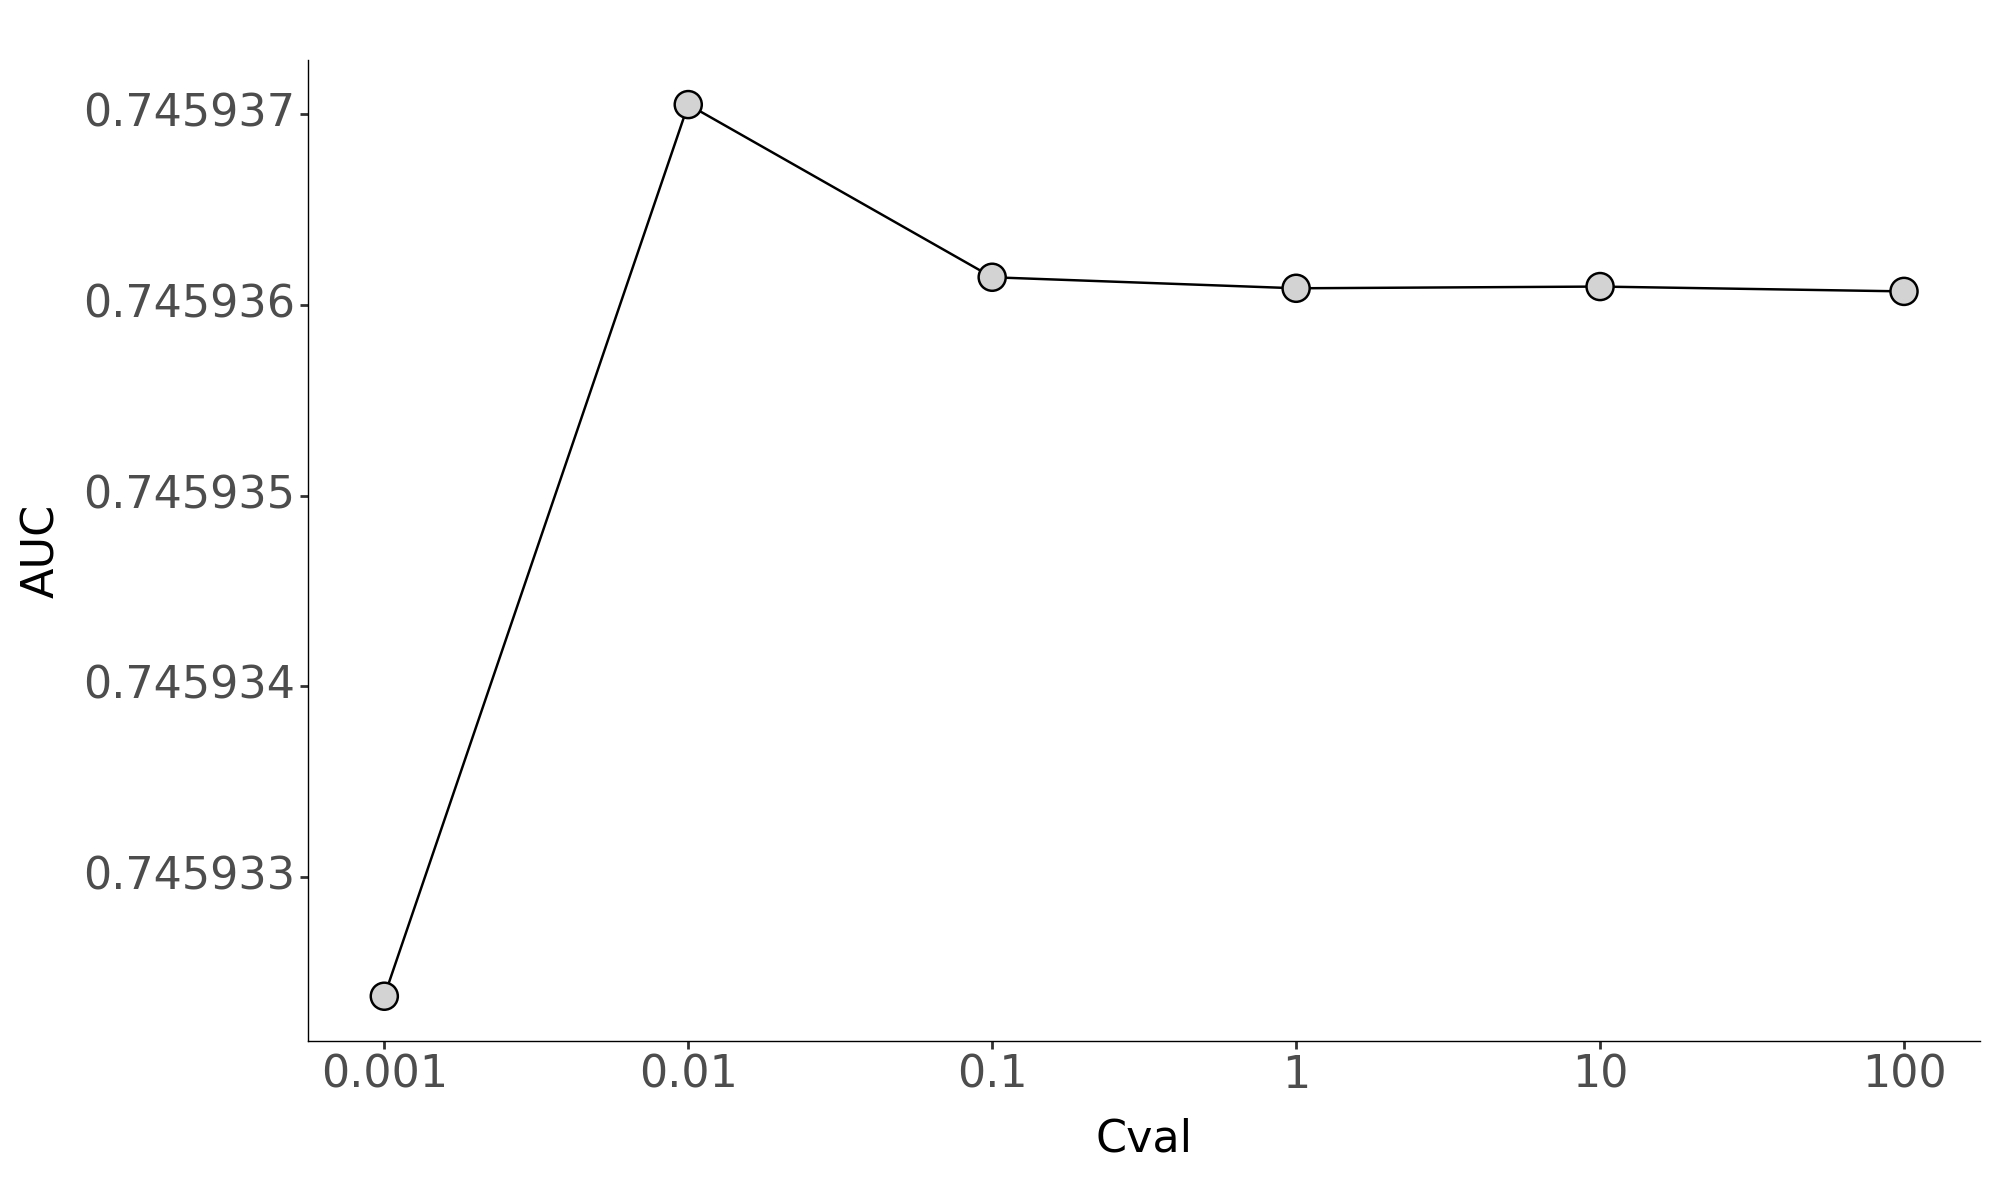

<Figure Size: (1000 x 600)>

In [ ]:
(
    ggplot(auc_data, aes(x = 'Cval', y = 'scores')) +
      geom_line() +
      geom_point(size = 5, fill = 'lightgray') +
      my_theme() +
      scale_x_log10(breaks = Cval) +
      ylab('AUC')
)

In [ ]:
# Use the best Cval (0.01) for test data.
clf = LogisticRegression(C = 0.01).fit(X_train, y_train)
y_hat = clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_hat)
auc

0.7500202002382853

In [ ]:
clf.coef_

array([[ 5.16300354e-03, -2.38403776e-01,  2.87748236e-02,
        -1.85455801e-02, -1.14280894e-01,  2.29686975e-01,
         3.56224835e-01,  4.15944865e-01,  4.55614542e-01,
        -5.01583268e-02,  2.35463923e-01,  1.72089842e-01,
         6.55335970e-02,  1.09982959e-01,  4.82008123e-02,
         7.20738343e-02,  1.53334614e-01, -1.18210287e-01,
         1.20434208e-01,  3.49888104e-02, -5.18745972e-02,
         5.49652047e-02, -1.46910393e-01, -2.90621193e-03,
        -2.90621193e-03,  0.00000000e+00,  1.66484953e-02,
         1.38424230e-02,  1.17624279e-02,  1.85755530e-03,
        -3.92462089e-04, -8.17431013e-03,  2.25805041e-02,
         1.88588584e-03,  1.79297595e-02, -6.16706623e-03,
         1.49147869e-02, -4.41579503e-03, -1.40285292e-03,
        -6.09540545e-03,  1.03254900e-04, -2.70313067e-01,
        -4.78205732e-02,  5.77046998e-02,  7.45134824e-02,
         4.52602750e-02, -3.75892449e-01]])

## References
* https://www.kaggle.com/adaubas/2nd-place-solution-categorical-fe-callenge

Lab explorations:

* Increase the hashing dimension for high cardinality features. Does it make a difference?
* Drop features with the 5 smallest coeficients (in absolute value). Does this make a difference?
* Try categorical encoding on a real life dataset with numeric and categorical predictors. Then fit a regularized regression and random forest and compare their performance and complexities.